In [1]:
import numpy as np 
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime as dt
import mplfinance as mpf

import time

import os
from os import listdir
from os.path import isfile, join

import seaborn as sns

# Regressions
import statsmodels.api as sm

In [2]:
# Default Values
PATH = "F:/Code/Python/Jupyter/Finance/datasets/Stock List/"
S_YEAR = 2017
S_MONTH = 1
S_DAY = 3
S_DATE_STR = f"{S_YEAR}-{S_MONTH}-{S_DAY}"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

E_YEAR = 2021
E_MONTH = 8
E_DAY = 19
E_DATE_STR = f"{E_YEAR}-{E_MONTH}-{E_DAY}"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)

In [3]:
# Function that returns a dataframe from a csv
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + ".csv", index_col='Date', parse_dates=True)
    except FileNotFoundError:
        print("File doesn't exist")
    else:
        return df

<h3>Regression Analysis</h3>
<p>Examine the relationship between 2 or more variables (Dependent/Independent variables).</p>
<p>Dependent: Price</p>
<p>Independent: Earnings, economic events, etc.</p>

<h3>Model Training</h3>
<p>The way we will be training our model is by firstly training it on the first group of data, which will be 80% of the usable data. The last 20% will be used to test the model. </p>

<h3>AutoRegressive Integrated Moving Average - ARIMA</h3>
<p>Based on prior values.</p>
<p>Able to play around with lag, datapoint begin and actual datapoints. Currently training on data which also includes a war and a pandemic.</p>

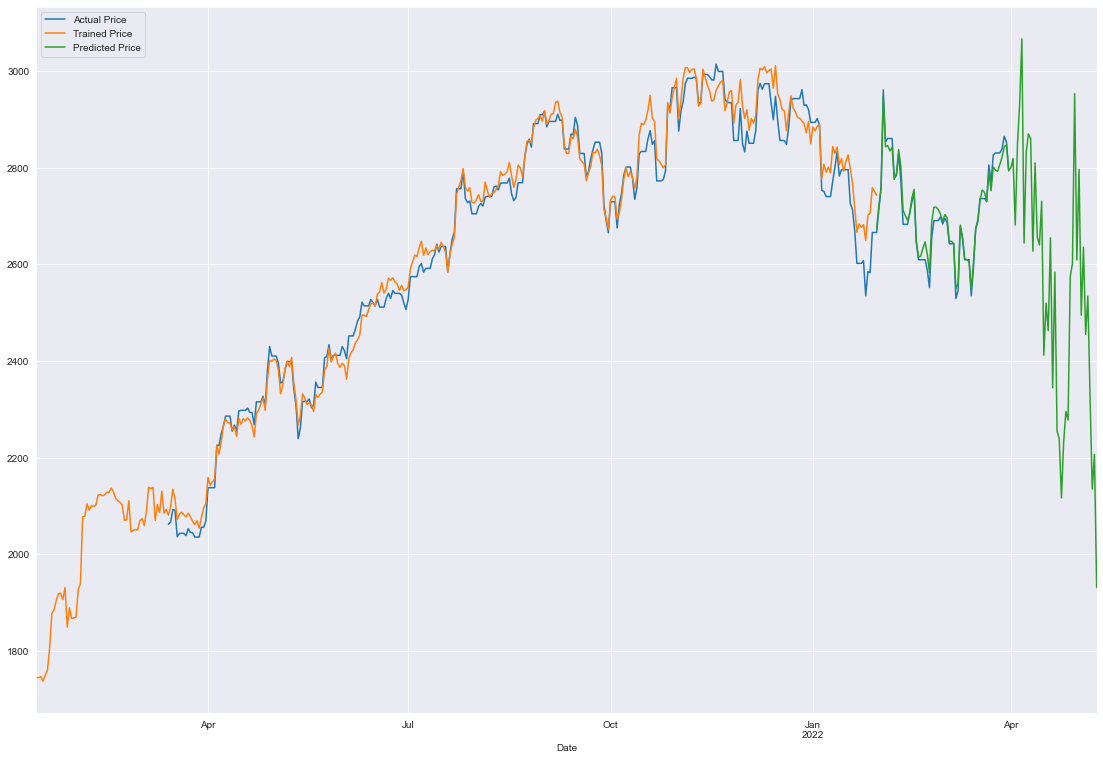

In [51]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Google DF settings
a_df = get_df_from_csv("GOOG")
a_df = a_df.asfreq('d') # Use daily prices
a_df = a_df.fillna(method='ffill') # Fill missing values

# Drop unnecessary columns
a_df.drop(a_df.columns[a_df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
a_df = a_df.drop(['daily_return'], axis=1)

# Create Seaborn plot
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters() # auto datetime conv
sns.mpl.rc('figure', figsize=(19, 13))

fig, ax = plt.subplots()

# Optimum lags (Time without new data, ex weekend)
lags = ar_select_order(a_df, maxlag=30)

# Create model
model = AutoReg(a_df['Adj Close'], lags.ar_lags)
model_fit = model.fit()

# Model Training settings based on df datapoints (len(a_df) == 1914)
#len(a_df) = 1914; 80% = 1531; 20% = 382
train_df = a_df.iloc[60:1531]
test_df = a_df.iloc[1531:]

# Actual training model
train_model = AutoReg(a_df['Adj Close'], 900).fit(cov_type="HC0")
start = len(train_df)
end = len(train_df) + len(test_df) - 1

pred = train_model.predict(start=start, end=end, dynamic=True)

# Predictions in plot
ax = test_df.plot(ax=ax) # Orange
ax = pred.plot(ax=ax) # Green

# 'Predict' next x days
next_days = 100
forecast = train_model.predict(start=end, end=end + next_days, dynamic=True)
ax = forecast.plot(ax=ax)

# Legend
plt.legend(labels=["Actual Price", "Trained Price", "Predicted Price"])